# Features
* Использует XLA компилятор, который определяет свой IR как HLO (High-Level Operations) для представления computational graphs
* pytorch и tensorflow выступают в роли frontend для XLA и могут представлять свой граф вычислений как HLO, но разработчики [рекомендуют](https://www.secretflow.org.cn/docs/spu/latest/en-US/getting_started/faq#does-spu-support-pytorch) использовать JAX
* PPHLO реализован как диалект MLIR (Multi-Level Intermidiate Representation) для MPC вычислений
* Не требует отдельного языка для описания моделей машинного обучения, использует pytorch и tensorflow как есть, компилируя их в HLO представление с помощью XLA
* MPC логика реализована на уровне HLO
* из коробки поддерживает разбиение фич по горизонтали и вертикали
* использует fixed point arithmetic из-за чего точность может отличаться от plaintext модели

# Архитектура
1) Программист пишет код в AI фреймворке(например TensorFlow/JAX).
2) AI frontend обходит DAG, и выдает XLA IR.
3) SPU компилятор переводит XLA IR в SPU IR, формат который SPU runtime понимает.

[Подробнее](https://www.secretflow.org.cn/docs/spu/latest/en-US/development/compiler)
- [MLIR](https://mlir.llvm.org/) Проект MLIR представляет собой новый подход к созданию повторно используемой и расширяемой инфраструктуры компилятора. MLIR направлен на решение проблемы фрагментации программного обеспечения, улучшение компиляции для гетерогенного оборудования, значительное снижение стоимости создания компиляторов для конкретной предметной области и помощь в объединении существующих компиляторов. 
- [XLA](https://www.tensorflow.org/xla/architecture) используется в качестве промежуточного уровня из платформ, таких как PyTorch, JAX и TensorFlow, в XLA, а затем постепенно отображая это на конкретное целевое железо. 
- [MLIR-HLO](https://github.com/tensorflow/mlir-hlo) Проект MLIR-HLO соединяет XLA с миром MLIR.

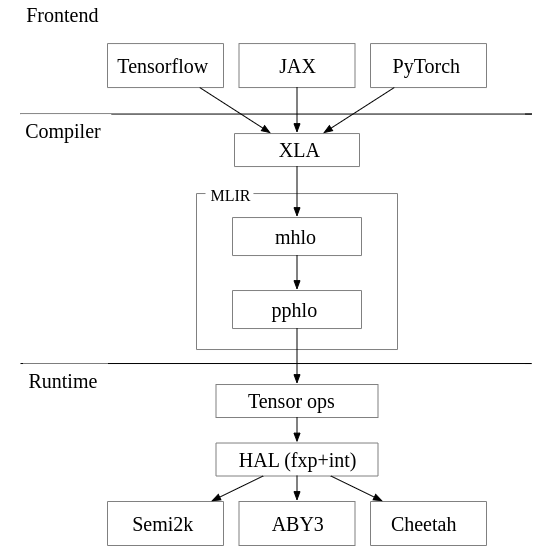 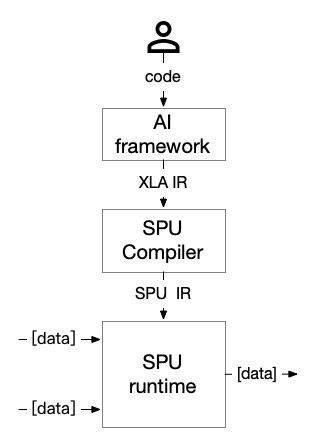 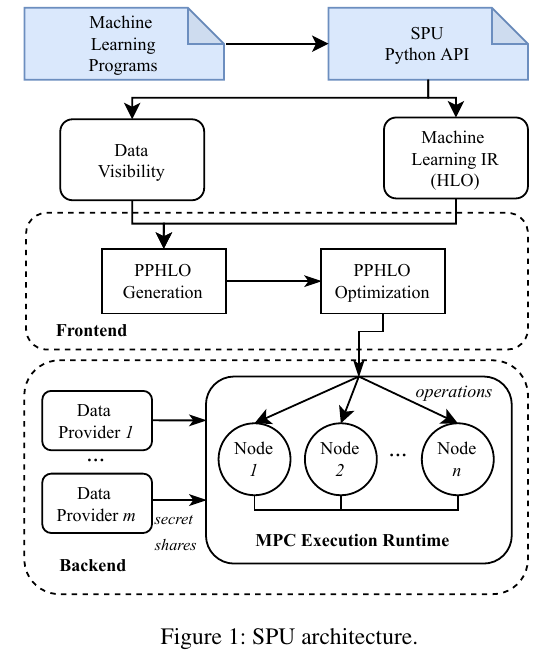 

Архитектура кодовой базы очень хорошо показана [тут](https://github.com/secretflow/spu/blob/main/REPO_LAYOUT.md)

## MLIR (Multi Level Intermediate Representation)
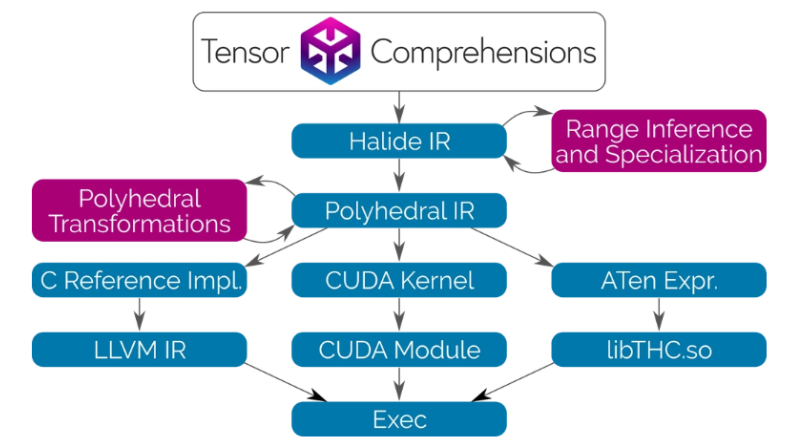

Это compiler intermediate representation которое использует [polyhedral loop optimization](https://en.wikipedia.org/wiki/Polytope_model). 
Этот гибридный дизайн оптимизирован для представления, анализа и преобразования dataflow graphs на абстрактном уровне, а также целевого кода, создаваемого для высокопроизводительных параллельных систем обработки данных.

- используется для написания domain specific кода компилятора, например:
  - Swift и Rust пишут свои промежуточные оптимизации перед тем как перевести код в IR для конечной оптимизации LLVM
  - Tensorflow использует концепцию Computation Graph, в котором они также выполняют специфичные для ML оптимизации
  - Компиляция СФ блоков https://circt.llvm.org/docs/GettingStarted/
  - SMPC имеет свое место для оптимизации - уменьшение раундов коммуникаций между участниками протокола и реализован как MLIR [диалект](https://github.com/secretflow/spu/tree/main/libspu/dialect)
- Предоставляет готовые абстрации, которые называются [диалектами](https://mlir.llvm.org/docs/Dialects/):
  - OpenACC для параллельного программирования
  - gpu - cuda, opencl, ...
  - Intel Advanced Matrix Extensions
  - async для асинхронного программирования
  - bufferization для отображения тензора на физическую память конкретного устройства
  - Linalg
  - ML graph
  - ml_program - structural operations and types for defining a compiled Machine-Learning program
  - tensor - hold core tensor creation and manipulation ops
- MLIR служит для унификации написания таких различных domain specific компиляторов, предоставляя для этого декларативный язык [TableGen](https://llvm.org/docs/TableGen/ProgRef.html), который намного легче использовать чем С++ для написания диалектов
- MLIR гарантирует автоматическую портабельность на новые доступные hardware платформы (типа GPU и TPU), совместимость с API (типа Neural Networks API в Android NDK, OpenMP) и реализация многопоточности из коробки
- Операции, написанные с помощью MLIR, применяются во время compiler passes по коду, то есть во время компиляции
- Пример кода на MLIR:

  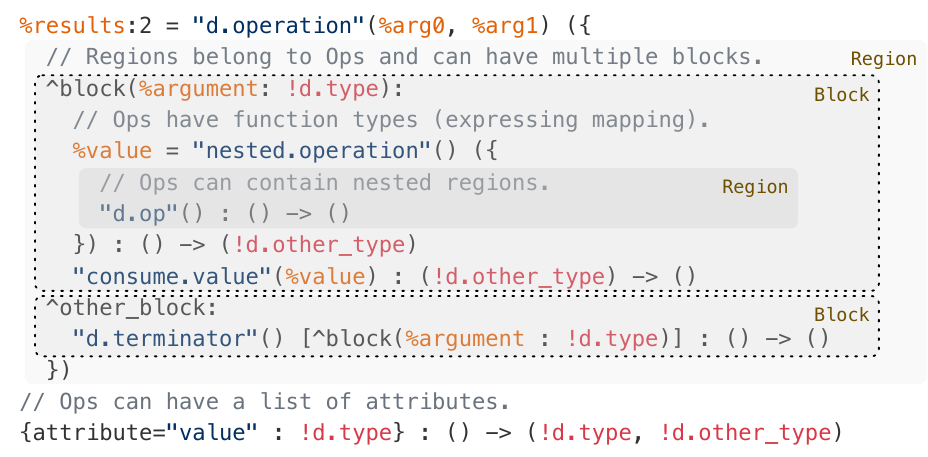
- Правила декларативного шаблона предпочтительнее императивного кода C++ по ряду причин: они более компактны, их легче понимать, для них могут быть написаны проверочные программы (типа static analysis)

In [18]:
import spu
import jax.numpy as jnp
import numpy as np

# import spu simulation module
import spu.utils.simulation as pps

# create a simulator with ABY3 x Ring64 protocol.
protocol = spu.ProtocolKind.ABY3
field = spu.FieldType.FM64
simulator = pps.Simulator.simple(3, protocol, field)

# decorate a jnp function to a simulated function
spu_add = pps.sim_jax(simulator, jnp.add)

# now we can call spu_fn like normal jnp fn.
x = np.array([[1.0, 2.0], [3.0, 4.0]])
y = np.array([[5.0, 6.0], [7.0, 8.0]])

# the function is simulated on SPU VM, which use 3 threads to simulate different parties.
# the actual progress is exactly the same as real distributed version.
z = spu_add(x, y)

print(spu_add.pphlo)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


module @xla_computation_add attributes {mhlo.cross_program_prefetches = [], mhlo.is_dynamic = false, mhlo.use_auto_spmd_partitioning = false} {
  func.func @main(%arg0: tensor<2x2x!pphlo.sec<f32>>, %arg1: tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>> {
    %0 = "pphlo.add"(%arg0, %arg1) : (tensor<2x2x!pphlo.sec<f32>>, tensor<2x2x!pphlo.sec<f32>>) -> tensor<2x2x!pphlo.sec<f32>>
    return %0 : tensor<2x2x!pphlo.sec<f32>>
  }
}



# Протоколы

На данный момент поддерживаются следующие 3 протокола, но можно добавлять новые:
* ABY3: A honest majority 3PC-protocol. SPU provides **semi-honest** implementation.
* SPDZ2k - **malicious** протокол с third-party стороной, которая генерит beaver tripples, на данный момоент он находится в [процессе разработки](https://github.com/secretflow/spu/tree/main/libspu/mpc/spdz2k). Вместо него сейчас демонстрируется Semi2k - урезанный SPDZ2k, из которого выкинули все malicious проверки, поэтому он **semi-honest**
* Cheetah : A fast 2pc **semi-honest** protocol. Не требует third party за счет выполнения дополнительных вычислений. Требует чтобы оба участника следовали спецификации протокола, причем один из них может быть [curious](https://wiki.mpcalliance.org/semi_honest_adversary.html) (он может пытаться подсмотреть inputs другого участника, но изменять код и данные не может).

[MPC status](https://www.secretflow.org.cn/docs/spu/latest/en-US/reference/mpc_status)

Есть [инструкция](https://www.secretflow.org.cn/docs/spu/latest/en-US/development/add_protocols) как можно добавить свой протокол.

#  PSIC (Private set intersection)

[Полное описание](https://www.secretflow.org.cn/docs/spu/latest/en-US/tutorials/psi)

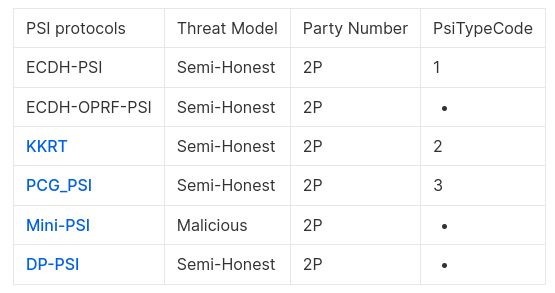

[psi_df](https://www.secretflow.org.cn/docs/secretflow/latest/en-US/source/secretflow.device.device.device#secretflow.device.device.spu.SPURuntime.psi_df) пересекает DataFrames по ключу.
Тут есть много примеров https://www.secretflow.org.cn/docs/spu/latest/en-US/tutorials/psi

Рекомендуют [KKRT16-PSI](https://www.secretflow.org.cn/docs/secretflow/latest/en-US/user_guide/psi#kkrt16-psi) (semi-honest), которое может за минуту пересекать множества состоящие из 2^24 элементов (128 битные строки) 

# WOE (Weight Of Evidence) encoding

Binning помогает нам преобразовать непрерывные переменные в категориальные. [Пример](https://www.secretflow.org.cn/docs/secretflow/latest/en-US/user_guide/preprocessing/WeightOfEvidenceEncoding)

In [7]:
import pandas as pd
import secretflow as sf
from secretflow.data.vertical import VDataFrame
from secretflow.utils.simulation.datasets import load_linear

In [13]:
sf.shutdown()
sf.init(['alice', 'bob'], address='local')
alice, bob = sf.PYU('alice'), sf.PYU('bob')
# similarly for woe in heu
spu = sf.SPU(sf.utils.testing.cluster_def(['alice', 'bob']))

2023-12-12 17:20:45,225	INFO worker.py:1538 -- Started a local Ray instance.


In [17]:
parts = {
    bob: (1, 11),
    alice: (11, 22),
}
vdf = load_linear(parts=parts)

INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party alice.


In [15]:
label_data = vdf['y']
y = sf.reveal(label_data.partitions[alice].data).values

In [16]:
from secretflow.preprocessing.binning.vert_woe_binning import VertWoeBinning
from secretflow.preprocessing.binning.vert_bin_substitution import VertBinSubstitution

binning = VertWoeBinning(spu)
bin_rules = binning.binning(
    vdf,
    binning_method="chimerge",
    bin_num=4,
    bin_names={alice: ['x14'], bob: ["x5", "x7"]},
    label_name="y",
)

woe_sub = VertBinSubstitution()
vdf = woe_sub.substitution(vdf, bin_rules)

# this is for demo only, be careful with reveal
print(sf.reveal(vdf.partitions[alice].data))
print(sf.reveal(vdf.partitions[bob].data))

INFO:root:Create proxy actor <class 'secretflow.preprocessing.binning.vert_woe_binning_pyu.VertWoeBinningPyuWorker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.preprocessing.binning.vert_woe_binning_pyu.VertWoeBinningPyuWorker'> with party bob.
(_run pid=90060) INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=90060) INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
(_run pid=90060) INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
(_run pid=90060) INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
(_run pid=90060) WARNING:jax._src.xla_bri

(_run pid=90060) [2023-12-12 17:21:03.387] [info] [thread_pool.cc:30] Create a fixed thread pool with size 3
(SPURuntime(device_id=None, party=bob) pid=90233) 2023-12-12 17:21:03.800 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 3
(SPURuntime(device_id=None, party=alice) pid=90231) 2023-12-12 17:21:03.857 [info] [thread_pool.cc:ThreadPool:30] Create a fixed thread pool with size 3


INFO:root:Create proxy actor <class 'secretflow.preprocessing.binning.vert_bin_substitution.VertBinSubstitutionPyuWorker'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.preprocessing.binning.vert_bin_substitution.VertBinSubstitutionPyuWorker'> with party alice.
INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party bob.
INFO:root:Create proxy actor <class 'secretflow.data.core.agent.PartitionAgent'> with party alice.


           x11       x12       x13       x14       x15       x16       x17  \
0     0.241531 -0.705729 -0.020094 -0.493792  0.851992  0.035219 -0.796096   
1    -0.402727  0.115744  0.468149 -0.735388  0.386395  0.712798  0.239583   
2     0.872675 -0.559321  0.390246 -0.079604  0.225594 -0.639674  0.279511   
3    -0.644718 -0.409382  0.141747 -0.682014  0.314084 -0.802476  0.348878   
4    -0.949669 -0.940787 -0.951708  0.232566  0.272346  0.124419  0.853226   
...        ...       ...       ...       ...       ...       ...       ...   
9995 -0.031331 -0.078700 -0.020636 -0.493792  0.210120 -0.288943 -0.262945   
9996  0.047039  0.965614 -0.921435 -0.251231  0.205778  0.155392  0.922683   
9997  0.269438 -0.115586  0.928880  0.513349  0.269042 -0.331772  0.520971   
9998  0.999325  0.433372 -0.805999  0.232566  0.072405  0.973399 -0.123470   
9999 -0.203443  0.772931 -0.146181 -0.305728  0.274590  0.803816 -0.312047   

           x18       x19       x20  y  
0     0.810261  0.04830

# Logistic regression

Пример логистической регрессии с разбиением фич по столбцам 
https://www.secretflow.org.cn/docs/secretflow/latest/en-US/tutorial/lr_with_spu